# Statistical Power Analysis: Sample Size Calculator

## Background

Our product team wants to optimize the checkout flow to improve purchase completion rates. Before running experiments, we need to determine the right sample size to reliably detect improvements.

This analysis calculates the required sample size and validates it through simulation to ensure we have adequate statistical power to detect meaningful changes.

In [3]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import math

np.random.seed(87654)
num_sims = 1000

control_rate = 0.22
treatment_rate = 0.26

# Calculate sample size using power analysis formula (2.8 represents 80% power at 5% significance)
sample_n = math.ceil(2*(control_rate*(1-control_rate)+treatment_rate*(1-treatment_rate))*
                    ((2.8/(treatment_rate-control_rate))**2))

print("Sample Size Needed:", sample_n)

Sample Size Needed: 3568


## Data Generation Function

In [5]:
def generate_data(sample_n, control_rate, treatment_rate):
    half_n = round(sample_n/2)
    data = pd.DataFrame(np.random.uniform(0,1,size=(sample_n,2)), columns=['group','randval'])
    data.iloc[0:half_n,0] = 0
    data.iloc[half_n:,0] = 1
    data['converted'] = 0
    data['converted'] = np.where((data['group']==0) & (data['randval']<control_rate), 1, data['converted'])
    data['converted'] = np.where((data['group']==1) & (data['randval']<treatment_rate), 1, data['converted'])
    return data

## Single Experiment Example

Run one sample experiment to demonstrate the approach

In [7]:
data = generate_data(sample_n, control_rate, treatment_rate)
formula = 'converted ~ group'
model = smf.ols(formula, data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              converted   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     11.80
Date:                Sun, 24 Aug 2025   Prob (F-statistic):           0.000598
Time:                        14:46:52   Log-Likelihood:                -2040.6
No. Observations:                3568   AIC:                             4085.
Df Residuals:                    3566   BIC:                             4097.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2192      0.010     21.588      0.0

## Power Validation Through Simulation

Each simulation generates new random data and runs a linear regression. Since there are no covariates, this regression gives the same result as a two-sample t-test.

In [9]:
def get_t_stats(num_sims):
    t_values = list()
    for i in range(num_sims):
        data = generate_data(sample_n, control_rate, treatment_rate)
        formula = 'converted ~ group'
        model = smf.ols(formula, data=data).fit()
        t = model.tvalues['group']
        t_values.append(t)
    return t_values

t_stats = get_t_stats(num_sims)
results = pd.DataFrame(t_stats, columns=['t_score'])
results['significant'] = np.where(np.abs(results['t_score'])>=1.96, 1, 0)

# Using the correct sample size with enough simulations should yield approximately 80% significant results
# This validates our power calculation since 2.8 coefficient corresponds to 80% power
print("Statistical Power:", results['significant'].mean())

Statistical Power: 0.796


## Visualization

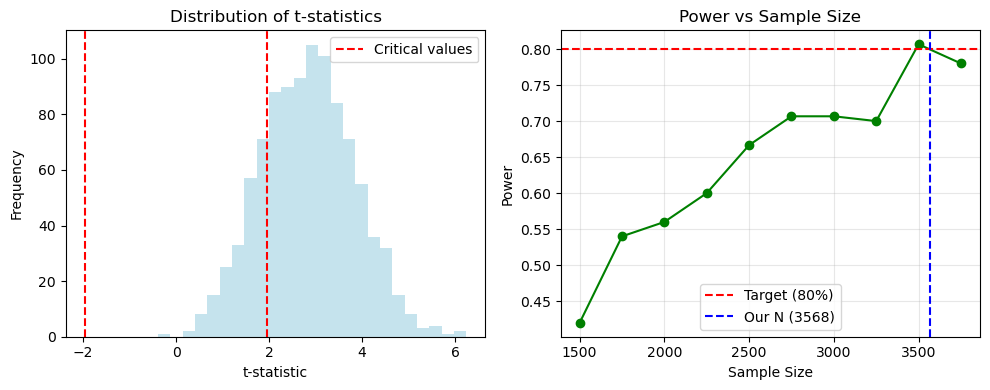

In [11]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(results['t_score'], bins=25, alpha=0.7, color='lightblue')
plt.axvline(-1.96, color='red', linestyle='--', label='Critical values')
plt.axvline(1.96, color='red', linestyle='--')
plt.xlabel('t-statistic')
plt.ylabel('Frequency')
plt.title('Distribution of t-statistics')
plt.legend()

plt.subplot(1,2,2)
sample_sizes = range(1500, 4000, 250)
power_vals = []
for n in sample_sizes:
    temp_stats = []
    for _ in range(150):
        temp_data = generate_data(n, control_rate, treatment_rate)
        temp_model = smf.ols('converted ~ group', data=temp_data).fit()
        temp_stats.append(temp_model.tvalues['group'])
    power = sum(1 for t in temp_stats if abs(t) >= 1.96) / len(temp_stats)
    power_vals.append(power)

plt.plot(sample_sizes, power_vals, 'o-', color='green')
plt.axhline(0.8, color='red', linestyle='--', label='Target (80%)')
plt.axvline(sample_n, color='blue', linestyle='--', label=f'Our N ({sample_n})')
plt.xlabel('Sample Size')
plt.ylabel('Power')
plt.title('Power vs Sample Size')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

We calculated a required sample size of 3,568 users to detect an improvement from 22% to 26% checkout completion rate with 80% statistical power.

The simulation validation showed an observed power of 79.6%, confirming our sample size calculation is appropriate. The left graph shows the distribution of t-statistics from our simulations, with most values falling beyond the critical threshold of ±1.96, indicating significant results. The right graph demonstrates how statistical power increases with sample size, confirming that our calculated sample size achieves the target power needed to reliably detect the treatment effect if it exists.